In [4]:
from  pathlib import Path
fraud_data = Path("../../../data/miscel/fraud_data.csv")
data_file = fraud_data.as_posix()

In [9]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.covariance import EllipticEnvelope 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef


In [5]:
df = pd.read_csv(data_file,index_col=0,nrows=10000)

(10000, 10)


,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,,,,,,,,,,
1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
7,PAYMENT,466.73,C517929856,881.0,414.27,M2128130537,0.0,0.0,0,0
7,PAYMENT,8239.66,C1483641522,11515.0,3275.34,M1108211033,0.0,0.0,0,0
7,PAYMENT,6063.34,C728110179,31409.0,25345.66,M277524255,0.0,0.0,0,0


number of Nan values  0
fraud proportion isFraud
0    99.32
1     0.68
Name: proportion, dtype: float64
fraud issue % 0.6799999999999999


<Axes: xlabel='isFraud', ylabel='count'>

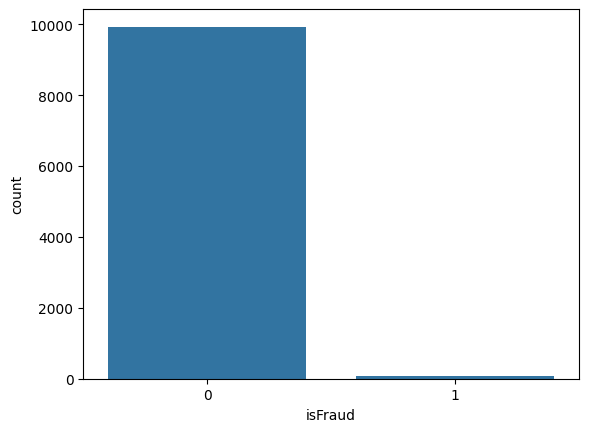

In [6]:
print (df.shape)
display (df)
print ("number of Nan values ",df.isna().sum().sum())
print ("fraud proportion",df["isFraud"].value_counts(normalize=True)*100)
fraud = (df["isFraud"].value_counts(normalize=True)*100)[1]
print ("fraud issue %", fraud)
sns.countplot(data=df,x="isFraud")


In [7]:
print (df.dtypes)

# create variables
y = df ["isFraud"]
# remove string variables
print (df["type"].unique())
df["type"] = df["type"].replace(to_replace=["TRANSFER","PAYMENT","CASH_OUT","CASH_IN","DEBIT"],value=[0,1,2,3,4]).astype(int)
X = df.drop(columns=["isFraud","nameOrig","nameDest","isFlaggedFraud"])

# split data
X_train,X_test,y_train,y_test = train_test_split (X,y,test_size=.2,random_state=42,stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


/tmp/ipykernel_1396/1265265661.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["type"] = df["type"].replace(to_replace=["TRANSFER","PAYMENT","CASH_OUT","CASH_IN","DEBIT"],value=[0,1,2,3,4]).astype(int)


In [10]:


def compute_statistics (results, model,y_test,y_pred_test) :
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0,average='micro')
    roc_auc =  roc_auc_score(y_test,y_pred_test)
    f1 = f1_score(y_test, y_pred_test,average='micro')
    matthews_coef = matthews_corrcoef(y_test,y_pred_test)
    # f1 = f1_score (y_test,y_pred_test,zero_dvision=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0,average='micro')

    print (f"{model} accuracy score {accuracy}  precision {precision} recall {recall}")
    print (f"{model}  roc_auc score {roc_auc} matthews_coef {matthews_coef}")

    results.append({
        'Model': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_score' : f1,
        'Roc_auc': roc_auc,
        'Matthews_coef': matthews_coef
    })



In [11]:
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, IsolationForest, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


param_grids = {}
models = {}

# random forest classifier
model = "RandomForestClassifier"
rf = RandomForestClassifier()
param_grid = {'n_estimators':[100], 'random_state':[42]}
param_grids[model] = param_grid
models[model] = rf

# Decision tree  classifier
model = "DecisionTreeClassifier"
dt = DecisionTreeClassifier()
param_grid = {'random_state':[42]}
param_grids[model] = param_grid
models[model] = dt

# kneighbour classifier
model = "KNeighborsClassifier"
k_neighbour = KNeighborsClassifier(algorithm="kd_tree",n_jobs=-1)
n_neighbors = list(range(1, 10))
param_grid = {"metric" : ["minkowski"],"n_neighbors" : n_neighbors}

param_grids[model] = param_grid
models[model] = k_neighbour

#  robust covariance
model = "EllipticEnvelope"
el = EllipticEnvelope(random_state=42)
param_grid = {
    'contamination': [0.001,0.002],  # Expected proportion of outliers
    'support_fraction': [0.8]  # Proportion of points to compute covariance
}

param_grids[model] = param_grid
models[model] = el

# SVM (SVC)
model = "SVM(SVC)"
param_grid = {'C':[0.1,1,10], 'kernel':['rbf','linear', 'poly'], 'gamma':[0.001, 0.1, 0.5]}
clf = svm.SVC()

param_grids[model] = param_grid
models[model] = clf

model= 'Gradient Boosting'
param_grid = {'n_estimators':[100], 'random_state':[42]}
gc = GradientBoostingClassifier()

param_grids[model] = param_grid
models[model] = gc

model= 'AdaBoost'
param_grid = {'n_estimators':[100], 'random_state':[42]}
ab = AdaBoostClassifier()

param_grids[model] = param_grid
models[model] = ab

# bagging classifier
model= 'Bagging'
param_grid = {'n_estimators':[100]}
bc = BaggingClassifier()

param_grids[model] = param_grid
models[model] = bc

# xgboost classifier
model = "XGBoost"
xg = XGBClassifier()
param_grid = {'learning_rate': [0.1,0.5], 'n_estimators': [100]}
param_grids[model] = param_grid
models[model] = xg

# bayes
model = "IsolationForest"
ifst = IsolationForest()
param_grid ={ "contamination" : np.linspace(0.01,0.05,10) ,"n_estimators" : [100,200,300]}
param_grids[model] = param_grid
models[model] = ifst

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

results = []
best_models = {}

for model_name in models.keys() :
    print(model_name)
    param_grid = param_grids[model_name]
    model = models[model_name]
    grid_search = GridSearchCV (estimator=model,param_grid=param_grid,cv=10,n_jobs=-1,scoring='accuracy')
    grid_search.fit(X_train_scaled,y_train)

    results_model= pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
    display(results_model.sort_values("mean_test_score",ascending=False).head(2))

    print (grid_search.best_estimator_)
    print (grid_search.best_params_)

    # Get the best model
    print(f"\n {model_name} classifier best estimator")
    best_parameter_model = grid_search.best_estimator_

    # Make predictions on test set
    y_pred_test = best_parameter_model.predict(X_test_scaled)

    if -1 in y_pred_test :
        y_pred_test [y_pred_test == -1] == 1
        y_pred_test [y_pred_test == 1] == 0
    
    best_models[model_name] = best_parameter_model

    # Calculate metrics
    compute_statistics(results,model_name,y_test,y_pred_test)

    # Classification report
    print(f"\n {model_name} Classification Report:")
    if model_name in ["EllipticEnvelope","IsolationForest"] :
        print(classification_report(y_test, y_pred_test))
    else :
        print(classification_report(y_test, y_pred_test, 
            target_names=['Normal (1)', 'Anomaly (-1)']))
  

print (results)




RandomForestClassifier


,mean_test_score,std_test_score,params
0,0.997125,0.001256,"{'n_estimators': 100, 'random_state': 42}"


RandomForestClassifier(random_state=42)
{'n_estimators': 100, 'random_state': 42}

 RandomForestClassifier classifier best estimator
RandomForestClassifier accuracy score 0.9985  precision 0.9985 recall 0.9985
RandomForestClassifier  roc_auc score 0.8928571428571428 matthews_coef 0.8857365275824984

 RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      1.00      1.00      1986
Anomaly (-1)       1.00      0.79      0.88        14

    accuracy                           1.00      2000
   macro avg       1.00      0.89      0.94      2000
weighted avg       1.00      1.00      1.00      2000

DecisionTreeClassifier


,mean_test_score,std_test_score,params
0,0.99675,0.002107,{'random_state': 42}


DecisionTreeClassifier(random_state=42)
{'random_state': 42}

 DecisionTreeClassifier classifier best estimator
DecisionTreeClassifier accuracy score 0.998  precision 0.998 recall 0.998
DecisionTreeClassifier  roc_auc score 0.9635304272766508 matthews_coef 0.8676230032385459

 DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      1.00      1.00      1986
Anomaly (-1)       0.81      0.93      0.87        14

    accuracy                           1.00      2000
   macro avg       0.91      0.96      0.93      2000
weighted avg       1.00      1.00      1.00      2000

KNeighborsClassifier


,mean_test_score,std_test_score,params
1,0.994375,0.001281,"{'metric': 'minkowski', 'n_neighbors': 2}"
0,0.994000,0.001658,"{'metric': 'minkowski', 'n_neighbors': 1}"


KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=2)
{'metric': 'minkowski', 'n_neighbors': 2}

 KNeighborsClassifier classifier best estimator
KNeighborsClassifier accuracy score 0.995  precision 0.995 recall 0.995
KNeighborsClassifier  roc_auc score 0.6428571428571428 matthews_coef 0.5331818183482253

 KNeighborsClassifier Classification Report:
              precision    recall  f1-score   support

  Normal (1)       0.99      1.00      1.00      1986
Anomaly (-1)       1.00      0.29      0.44        14

    accuracy                           0.99      2000
   macro avg       1.00      0.64      0.72      2000
weighted avg       1.00      0.99      0.99      2000

EllipticEnvelope


,mean_test_score,std_test_score,params
0,0.00675,0.001392,"{'contamination': 0.001, 'support_fraction': 0.8}"
1,0.00675,0.001392,"{'contamination': 0.002, 'support_fraction': 0.8}"


EllipticEnvelope(contamination=0.001, random_state=42, support_fraction=0.8)
{'contamination': 0.001, 'support_fraction': 0.8}

 EllipticEnvelope classifier best estimator
EllipticEnvelope accuracy score 0.007  precision 0.007 recall 0.007
EllipticEnvelope  roc_auc score 0.5002517623363545 matthews_coef 0.0009389403504651137

 EllipticEnvelope Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1986
           1       0.01      1.00      0.01        14

    accuracy                           0.01      2000
   macro avg       0.00      0.33      0.00      2000
weighted avg       0.00      0.01      0.00      2000

SVM(SVC)


/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

,mean_test_score,std_test_score,params
8,0.994000,0.000935,"{'C': 0.1, 'gamma': 0.5, 'kernel': 'poly'}"
17,0.993875,0.001179,"{'C': 1, 'gamma': 0.5, 'kernel': 'poly'}"


SVC(C=0.1, gamma=0.5, kernel='poly')
{'C': 0.1, 'gamma': 0.5, 'kernel': 'poly'}

 SVM(SVC) classifier best estimator
SVM(SVC) accuracy score 0.994  precision 0.994 recall 0.994
SVM(SVC)  roc_auc score 0.5714285714285714 matthews_coef 0.376827735177683

 SVM(SVC) Classification Report:
              precision    recall  f1-score   support

  Normal (1)       0.99      1.00      1.00      1986
Anomaly (-1)       1.00      0.14      0.25        14

    accuracy                           0.99      2000
   macro avg       1.00      0.57      0.62      2000
weighted avg       0.99      0.99      0.99      2000

Gradient Boosting


,mean_test_score,std_test_score,params
0,0.996625,0.001375,"{'n_estimators': 100, 'random_state': 42}"


GradientBoostingClassifier(random_state=42)
{'n_estimators': 100, 'random_state': 42}

 Gradient Boosting classifier best estimator
Gradient Boosting accuracy score 0.9965  precision 0.9965 recall 0.9965
Gradient Boosting  roc_auc score 0.8563875701337937 matthews_coef 0.7394955662177392

 Gradient Boosting Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      1.00      1.00      1986
Anomaly (-1)       0.77      0.71      0.74        14

    accuracy                           1.00      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       1.00      1.00      1.00      2000

AdaBoost


,mean_test_score,std_test_score,params
0,0.996875,0.001008,"{'n_estimators': 100, 'random_state': 42}"


AdaBoostClassifier(n_estimators=100, random_state=42)
{'n_estimators': 100, 'random_state': 42}

 AdaBoost classifier best estimator
AdaBoost accuracy score 0.997  precision 0.997 recall 0.997
AdaBoost  roc_auc score 0.8211768090922169 matthews_coef 0.7592788042290242

 AdaBoost Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      1.00      1.00      1986
Anomaly (-1)       0.90      0.64      0.75        14

    accuracy                           1.00      2000
   macro avg       0.95      0.82      0.87      2000
weighted avg       1.00      1.00      1.00      2000

Bagging


,mean_test_score,std_test_score,params
0,0.99775,0.001225,{'n_estimators': 100}


BaggingClassifier(n_estimators=100)
{'n_estimators': 100}

 Bagging classifier best estimator
Bagging accuracy score 0.9985  precision 0.9985 recall 0.9985
Bagging  roc_auc score 0.8928571428571428 matthews_coef 0.8857365275824984

 Bagging Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      1.00      1.00      1986
Anomaly (-1)       1.00      0.79      0.88        14

    accuracy                           1.00      2000
   macro avg       1.00      0.89      0.94      2000
weighted avg       1.00      1.00      1.00      2000

XGBoost


,mean_test_score,std_test_score,params
0,0.997625,0.001038,"{'learning_rate': 0.1, 'n_estimators': 100}"
1,0.997250,0.001458,"{'learning_rate': 0.5, 'n_estimators': 100}"


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)
{'learning_rate': 0.1, 'n_estimators': 100}

 XGBoost classifier best estimator
XGBoost accuracy score 0.9995  precision 0.9995 recall 0.9995
XGBoost  roc_auc score 0.9642857142857143 matthews_coef 0.9633815989812085

 XGBoost Classification

,mean_test_score,std_test_score,params
0,0.0065,0.001346,"{'contamination': 0.01, 'n_estimators': 100}"
1,0.0065,0.001346,"{'contamination': 0.01, 'n_estimators': 200}"


IsolationForest(contamination=np.float64(0.01))
{'contamination': np.float64(0.01), 'n_estimators': 100}

 IsolationForest classifier best estimator
IsolationForest accuracy score 0.007  precision 0.007 recall 0.007
IsolationForest  roc_auc score 0.5050352467270895 matthews_coef 0.004219167846624928

 IsolationForest Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1986
           1       0.01      1.00      0.01        14

    accuracy                           0.01      2000
   macro avg       0.00      0.33      0.00      2000
weighted avg       0.00      0.01      0.00      2000

[{'Model': 'RandomForestClassifier', 'Accuracy': 0.9985, 'Precision': 0.9985, 'Recall': 0.9985, 'F1_score': 0.9985, 'Roc_auc': 0.8928571428571428, 'Matthews_coef': 0.8857365275824984}, {'Model': 'DecisionTreeClassifier', 'Accuracy': 0.998, 'Precision': 0.998, 'Recall': 0.998, 

/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [13]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1_score', ascending=False)

display(results_df)

best_model_name = results_df.iloc[0]['Model']
print ("best model {best_model_name}")
best_model = best_models[best_model_name]

# Detailed evaluation of best model
y_pred_best = best_model.predict(X_test_scaled)

if -1 in y_pred_test :
        y_pred_test [y_pred_test == -1] == 1
        y_pred_test [y_pred_test == 1] == 0

print(f"\nClassification Report: for {best_model_name}")
print(classification_report(y_test, y_pred_test))
print("\nConfusion Matrix: for {best_model_name}")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)
print(f"\nTrue Negatives (no fraud): {cm[0][0]}")
print(f"False Positives: (declared as fraud , but no fraud) : {cm[0][1]}")
print(f"False Negatives: (declared as not fraud, but is fraud) : {cm[1][0]}")
print(f"True Positives: (true fraud) : {cm[1][1]}")


feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
print(feature_importance.head(10).to_string(index=False))


,Model,Accuracy,Precision,Recall,F1_score,Roc_auc,Matthews_coef
8,XGBoost,0.9995,0.9995,0.9995,0.9995,0.964286,0.963382
0,RandomForestClassifier,0.9985,0.9985,0.9985,0.9985,0.892857,0.885737
7,Bagging,0.9985,0.9985,0.9985,0.9985,0.892857,0.885737
1,DecisionTreeClassifier,0.9980,0.9980,0.9980,0.9980,0.963530,0.867623
6,AdaBoost,0.9970,0.9970,0.9970,0.9970,0.821177,0.759279
5,Gradient Boosting,0.9965,0.9965,0.9965,0.9965,0.856388,0.739496
2,KNeighborsClassifier,0.9950,0.9950,0.9950,0.9950,0.642857,0.533182
4,SVM(SVC),0.9940,0.9940,0.9940,0.9940,0.571429,0.376828
3,EllipticEnvelope,0.0070,0.0070,0.0070,0.0070,0.500252,0.000939
9,IsolationForest,0.0070,0.0070,0.0070,0.0070,0.505035,0.004219


best model {best_model_name}

Classification Report: for XGBoost
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1986
           1       0.01      1.00      0.01        14

    accuracy                           0.01      2000
   macro avg       0.00      0.33      0.00      2000
weighted avg       0.00      0.01      0.00      2000


Confusion Matrix: for {best_model_name}
[[1986    0]
 [   1   13]]

True Negatives (no fraud): 1986
False Positives: (declared as fraud , but no fraud) : 0
False Negatives: (declared as not fraud, but is fraud) : 1
True Positives: (true fraud) : 13
       feature  importance
newbalanceOrig    0.493553
 oldbalanceOrg    0.196545
          type    0.110055
oldbalanceDest    0.090468
newbalanceDest    0.061379
        amount    0.048001


/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [14]:
#  fraud stats on tests data
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

actual_fraud_nb = (y_test == 1).sum()
detected_fraud_nb = (y_pred_test == 1).sum()

print(f"Actual number of fraudulous transactions in test set: {actual_fraud_nb}")
print(f"Number of Transactions flagged as fraud: {detected_fraud_nb}")


# Create a dataframe with test data and predictions
target_col ="IsFraud"
test_results = X_test.copy()
test_results[target_col] = y_test.values
test_results['predicted_fraud'] = y_pred_test
test_results['fraud_probability'] = y_pred_proba

# Get all transactions predicted as fraud
detected_fraud = test_results[test_results['predicted_fraud'] == 1].copy()
detected_fraud = detected_fraud.sort_values('fraud_probability', ascending=False)

print(f"\nTotal fraudulent transactions detected: {len(detected_fraud)}")
print(f"Correctly identified frauds: {(detected_fraud[target_col] == 1).sum()}")
print(f"False positives: {(detected_fraud[target_col] == 0).sum()}")

# Summary statistics
print("\n" + "="*60)
print("Detection summary")
print("="*60)
actual_frauds = (y_test == 1).sum()
detected_frauds = (y_pred_test == 1).sum()
correct_detections = ((y_test == 1) & (y_pred_test == 1)).sum()

print(f"Actual fraudulent transactions in test set: {actual_frauds}")
print(f"Transactions flagged as fraud by model: {detected_frauds}")
print(f"Correctly detected frauds: {correct_detections}")
print(f"Detection rate: {(correct_detections/actual_frauds)*100:.2f}%")
print(f"Precision: {(correct_detections/detected_frauds)*100:.2f}%" if detected_frauds > 0 else "N/A")



Actual number of fraudulous transactions in test set: 14
Number of Transactions flagged as fraud: 1980

Total fraudulent transactions detected: 1980
Correctly identified frauds: 14
False positives: 1966

Detection summary
Actual fraudulent transactions in test set: 14
Transactions flagged as fraud by model: 1980
Correctly detected frauds: 14
Detection rate: 100.00%
Precision: 0.71%


In [15]:
# -----------------------------
# Detect Fraudulent Transactions
# -----------------------------
df["fraud_probability"] = best_model.predict_proba(X)[:, 1]
df["fraud_prediction"] = best_model.predict(X)

fraud_transactions = df[df["fraud_prediction"] == 1]

display (fraud_transactions)


,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,fraud_probability,fraud_prediction
step,,,,,,,,,,,,


In [ ]:
# Insérer votre code ici
from sklearn.covariance import EllipticEnvelope 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef


import warnings


param_grid = {
    'contamination': [0.001,0.002],  # Expected proportion of outliers
    'support_fraction': [0.8]  # Proportion of points to compute covariance
}


#  robust covariance
el = EllipticEnvelope(random_state=42)

print("\nStarting GridSearchCV...")
grid_search = GridSearchCV(
    estimator=el,
    param_grid=param_grid,
    scoring="accuracy",  # Custom scoring for anomaly detection
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print (grid_search.best_estimator_)
print (grid_search.best_params_)

print("\nEllipticEnvelope best parameters")
print(f"\nBest parameters: {grid_search.best_params_}")

# Get the best model
print("\nEllipticEnvelope best estimator")
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred_test = best_model.predict(X_test_scaled)

y_pred_test [y_pred_test == -1] == 1
y_pred_test [y_pred_test == 1] == 0

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
roc_auc =  roc_auc_score(y_test,y_pred_test)
matthews_coef = matthews_corrcoef(y_test,y_pred_test)
print (f"accuracy score {accuracy} roc_auc score {roc_auc} matthews_coef {matthews_coef}")


# Classification report
print("\nEllipticEnvelope Classification Report:")
el_cr = classification_report(y_test, y_pred_test)
print(el_cr)

# Confusion matrix
el_cm = confusion_matrix(y_test, y_pred_test)
print("\n EllipticEnvelope Confusion Matrix:")
print(el_cm)



In [ ]:
# Define parameter grid
param_grid = {
    'eps': [0.1, 0.3, 0.5],
    'min_samples': [3, 5],
    'metric': ['euclidean', 'manhattan']
}

# Create DBSCAN instance
dbscan = DBSCAN()

grid_search = GridSearchCV(
    estimator=dbscan,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,  
    n_jobs=-1
)

grid_search.fit(X_train_scaled)

# Best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best silhouette score: {grid_search.best_score_:.4f}")

# Fit final model with best parameters
best_model = grid_search.best_estimator_

best_model.fit_predict (X_test_scaled)

y_pred_dbscan = best_model.labels_

y_pred_dbscan[y_pred_dbscan == -1] = 1
y_pred_dbscan[y_pred_dbscan != -1 ] = 0

print ("dbscan accuracy score", accuracy_score (y_test,y_pred_dbscan))
print ("dbscan classification_report \n", classification_report (y_test,y_pred_dbscan))

print ("dbscan confusion matrix\n", confusion_matrix (y_test,y_pred_dbscan))
print ("dbscan roc auc score", roc_auc_score (y_test,y_pred_dbscan))
print ("dbscan matthews_corrcoef", matthews_corrcoef (y_test,y_pred_dbscan))


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve

# lof
lof = LocalOutlierFactor (n_neighbors=10, algorithm='auto', metric='euclidean', contamination=0.002)
y_pred_lof = lof.fit_predict(X_train_scaled)

# shift values
y_pred_lof [y_pred_lof == 1] = 0
y_pred_lof [y_pred_lof == -1] = 1

n_errors = (y_pred_lof !=y_train).sum()
print ("nerrors",n_errors)

print ("lof model accuracy" , accuracy_score(y_train,y_pred_lof))
print ("matthews_corrcoef" , matthews_corrcoef(y_train,y_pred_lof))
print ("roc_auc_score" , roc_auc_score(y_train,y_pred_lof))

print ("lof classification report" , classification_report(y_train,y_pred_lof))


confusion_matrix (y_train,y_pred_lof)

In [ ]:
from sklearn.cluster import DBSCAN

# dbScan


dbscan = DBSCAN(eps = 0.1, min_samples = 3, metric ="euclidean")

dbscan.fit(X_train_scaled)

y_pred_dbscan = dbscan.labels_

y_pred_dbscan[y_pred_dbscan == -1] = 1
y_pred_dbscan[y_pred_dbscan != -1 ] = 0

print ("dbscan accuracy score", accuracy_score (y_train,y_pred_dbscan))
print ("dbscan classification_report\n", classification_report (y_train,y_pred_dbscan))

print ("dbscan confusion matrix\n", confusion_matrix (y_train,y_pred_dbscan))
print ("dbscan roc auc score", roc_auc_score (y_train,y_pred_dbscan))
print ("dbscan matthews_corrcoef", matthews_corrcoef (y_train,y_pred_dbscan))